In [2]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.operators.sampling.lhs import LatinHypercubeSampling
from pymoo.optimize import minimize as moo_minimize
from pymoo.algorithms.moo.nsga3 import ReferenceDirectionSurvival
from pymoode.nsder import NSDER
from pymoode.gde3 import GDE3
from pymoo.factory import get_reference_directions

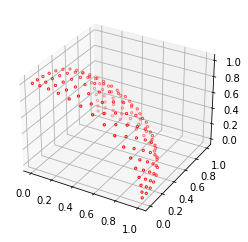

<Axes3DSubplot:>

In [3]:
from pymoo.factory import get_problem
from pymoo.util.plotting import plot

problem = get_problem("dtlz2")
plot(problem.pareto_front(), no_fill=True)

In [4]:
lhs = LatinHypercubeSampling()

In [5]:
NGEN = 250
POPSIZE = 136
SEED = 3

In [6]:
problem.__dict__

{'k': 8,
 'n_var': 10,
 'n_obj': 3,
 'n_constr': 0,
 'data': {'type_var': numpy.float64},
 'xl': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'xu': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'callback': None,
 'check_inconsistencies': True,
 'replace_nan_values_by': inf,
 'exclude_from_serialization': [],
 '_pareto_set': <pymoo.util.cache.Cache at 0x2557f02da00>,
 '_pareto_front': <pymoo.util.cache.Cache at 0x2557f6087c0>,
 '_ideal_point': None,
 '_nadir_point': None}

In [7]:
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=15)

In [8]:
ref_dirs.shape

(136, 3)

In [9]:
import numpy as np
from pymoo.algorithms.moo.nsga2 import calc_crowding_distance
from pymoo.util.randomized_argsort import randomized_argsort
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.core.survival import Survival, split_by_feasibility
from pymoo.core.population import Population
from pymoo.util.misc import find_duplicates
from scipy.spatial.distance import pdist, squareform


def get_crowding_function(label):

    if label == "cd":
        fun = calc_crowding_distance
    elif label == "ce":
        fun = calc_crowding_entropy
    elif label == "mnn":
        fun = calc_mnn
    else:
        raise KeyError("Crwoding function not defined")
    return fun

class RankSurvival(Survival):

    def __init__(self,
                 nds=None,
                 rule="full",
                 crowding_func="cd"):
        """A generalization of the NSGA-II survival operator that ranks individuals by dominance criteria
        and sorts the last front by some crowding metric.

        Args:
            nds (str or None, optional): Pymoo type of non-dominated sorting. Defaults to None.
            rule (str, optional): Rule to remove individuals exceeding popsize. Options are:
                "full", "sqrt", and "single". The rule "full" corresponds to the original version,
                in which all individuals exceeding the front are removed at onde. Other options remove
                individuals recursively and recalculate metrics at each iteration, which helps improving
                diversity, although is more computationally expensive. Defaults to "full".
            crowding_func (str or callable, optional): Crowding metric. Options are:
                "cd": crowding distances
                "ce": crowding entropy
                "cdsd": squared diagonal of crowding distances hypercube
                "cde": crowding diagonal entropy
                "dhv": diagonal of hypervolume added from neighbors.
                If callable, it takes objective functions as the unique argument and must return metrics.
                Defaults to "cd".
        """
        
        if not hasattr(crowding_func, "__call__"):
            crowding_func = get_crowding_function(crowding_func)

        super().__init__(filter_infeasible=True)
        self.nds = nds if nds is not None else NonDominatedSorting()
        self.rule = rule
        self.crowding_func = crowding_func
        
    def _do(self,
            problem,
            pop,
            *args,
            n_survive=None,
            **kwargs):

        # get the objective space values and objects
        F = pop.get("F").astype(float, copy=False)

        # the final indices of surviving individuals
        survivors = []

        # do the non-dominated sorting until splitting front
        fronts = self.nds.do(F, n_stop_if_ranked=n_survive)

        for k, front in enumerate(fronts):

            # current front sorted by crowding distance if splitting
            while len(survivors) + len(front) > n_survive:
                
                # re-calculate the crowding distance of the front
                crowding_of_front = self.crowding_func(F[front, :])
                I = randomized_argsort(crowding_of_front, order='descending', method='numpy')
                
                if self.rule == "full":
                    n_remove = len(survivors) + len(front) - n_survive
                elif self.rule == "single":
                    n_remove = 1
                elif self.rule == "sqrt":
                    n_remove = int(np.sqrt(len(survivors) + len(front) - n_survive))
                
                I = I[:-n_remove]
                front = front[I]

            # otherwise take the whole front unsorted
            else:
                # calculate the crowding distance of the front
                crowding_of_front = self.crowding_func(F[front, :])

            # save rank and crowding in the individual class
            for j, i in enumerate(front):
                pop[i].set("rank", k)
                pop[i].set("crowding", crowding_of_front[j])

            # extend the survivors by all or selected individuals
            survivors.extend(front)

        return pop[survivors]


class ConstrainedRankSurvival(Survival):
    
    def __init__(self, nds=None, ranking=None):
        """The Rank and Crowding survival approach for handling constraints proposed on
        GDE3 by Kukkonen, S. and Lampinen, J. (2005).

        Args:
            nds (str or None, optional): Pymoo type of non-dominated sorting. Defaults to None.
            ranking (Survival, optional): Basic survival operator. Defaults to None,
            which creates a RankSurvival instance.
        """
        super().__init__(filter_infeasible=False)
        self.nds = nds if nds is not None else NonDominatedSorting()
        self.ranking = ranking if ranking is not None else RankSurvival()
    
    def _do(self,
            problem,
            pop,
            *args,
            n_survive=None,
            **kwargs):

        if n_survive is None:
            n_survive = len(pop)

        n_survive = min(n_survive, len(pop))

        #If the split should be done beforehand
        if problem.n_constr > 0:

            #Split by feasibility
            feas, infeas = split_by_feasibility(pop, eps=0.0, sort_infeasbible_by_cv=True)

            #Obtain len of feasible
            n_feas = len(feas)

            #Assure there is at least_one survivor
            if n_feas == 0:
                survivors = Population()
            else:
                survivors = self.ranking.do(problem, pop[feas], *args, n_survive=min(len(feas), n_survive), **kwargs)

            #Calculate how many individuals are still remaining to be filled up with infeasible ones
            n_remaining = n_survive - len(survivors)

            #If infeasible solutions need to be added
            if n_remaining > 0:
                
                #Constraints to new ranking
                G = pop[infeas].get("G")
                G = np.maximum(G, 0)
                
                #Fronts in infeasible population
                infeas_fronts = self.nds.do(G, n_stop_if_ranked=n_remaining)
                
                #Iterate over fronts
                for k, front in enumerate(infeas_fronts):

                    #Save ranks
                    pop[infeas][front].set("cv_rank", k)

                    #Current front sorted by CV
                    if len(survivors) + len(front) > n_survive:
                        
                        #Obtain CV of front
                        CV = pop[infeas][front].get("CV").flatten()
                        I = randomized_argsort(CV, order='ascending', method='numpy')
                        I = I[:(n_survive - len(survivors))]

                    #Otherwise take the whole front unsorted
                    else:
                        I = np.arange(len(front))

                    # extend the survivors by all or selected individuals
                    survivors = Population.merge(survivors, pop[infeas][front[I]])

        else:
            survivors = self.ranking.do(problem, pop, *args, n_survive=n_survive, **kwargs)

        return survivors


def calc_crowding_entropy(F, filter_out_duplicates=True):
    n_points, n_obj = F.shape

    if n_points <= 2:
        return np.full(n_points, np.inf)

    else:

        if filter_out_duplicates:
            # filter out solutions which are duplicates - duplicates get a zero finally
            is_unique = np.where(np.logical_not(find_duplicates(F, epsilon=1e-32)))[0]
        else:
            # set every point to be unique without checking it
            is_unique = np.arange(n_points)

        # index the unique points of the array
        _F = F[is_unique]

        # sort each column and get index
        I = np.argsort(_F, axis=0, kind='mergesort')

        # sort the objective space values for the whole matrix
        _F = _F[I, np.arange(n_obj)]

        # calculate the distance from each point to the last and next
        dist = np.row_stack([_F, np.full(n_obj, np.inf)]) - np.row_stack([np.full(n_obj, -np.inf), _F])

        # calculate the norm for each objective - set to NaN if all values are equal
        norm = np.max(_F, axis=0) - np.min(_F, axis=0)
        norm[norm == 0] = np.nan

        # prepare the distance to last and next vectors
        dl = dist.copy()[:-1]
        du = dist.copy()[1:]
        
        #Fix nan
        dl[np.isnan(dl)] = 0.0
        du[np.isnan(du)] = 0.0
        
        #Total distance
        cd = dl + du

        #Get relative positions
        pl = (dl[1:-1] / cd[1:-1])
        pu = (du[1:-1] / cd[1:-1])

        #Entropy
        entropy = np.row_stack([np.full(n_obj, np.inf),
                                -(pl * np.log2(pl) + pu * np.log2(pu)),
                                np.full(n_obj, np.inf)])
        
        #Crowding entropy
        J = np.argsort(I, axis=0)
        _cej = cd[J, np.arange(n_obj)] * entropy[J, np.arange(n_obj)] / norm
        _cej[np.isnan(_cej)] = 0.0
        _ce = _cej.sum(axis=1)

        #Save the final vector which sets the crowding distance for duplicates to zero to be eliminated
        ce = np.zeros(n_points)
        ce[is_unique] = _ce

    return ce


def calc_mnn(F, filter_out_duplicates=True):
    n_points, n_obj = F.shape

    if n_points <= 2:
        return np.full(n_points, np.inf)

    else:

        if filter_out_duplicates:
            # filter out solutions which are duplicates - duplicates get a zero finally
            is_unique = np.where(np.logical_not(find_duplicates(F, epsilon=1e-32)))[0]
        else:
            # set every point to be unique without checking it
            is_unique = np.arange(n_points)

        # index the unique points of the array
        _F = F[is_unique].copy()

        # calculate the norm for each objective - set to NaN if all values are equal
        norm = np.max(_F, axis=0) - np.min(_F, axis=0)
        norm[norm == 0] = 1.0
        
        # F normalized
        _F = (_F - _F.min(axis=0)) / norm
        
        # Distances pairwise (inneficient)
        D = pdist(_F, metric="euclidean")
        D = squareform(D)
        
        # M neighbors
        M = _F.shape[1]
        _D = np.sort(D, axis=1)[:, 1: M + 1]
        
        # Metric d
        _d = np.prod(_D, axis=1)  
        
        # Set top performers as np.inf
        _extremes = np.argmin(_F, axis=0)
        _d[_extremes] = np.inf

        # Save the final vector which sets the crowding distance for duplicates to zero to be eliminated
        d = np.zeros(n_points)
        d[is_unique] = _d

    return d

In [10]:
gde3 = GDE3(pop_size=POPSIZE, CR=0.2, F=(0.1, 1.0), sampling=lhs, gamma=1e-4, refpoint=1,
            variant="DE/ranked/1/bin", SA=0.5,
            #survival=ReferenceDirectionSurvival(ref_dirs),
            survival=RankSurvival(rule="single", crowding_func="mnn")
            )

res_gde3 = moo_minimize(problem,
                        gde3,
                        ('n_gen', NGEN),
                         seed=SEED,
                         save_history=True,
                         verbose=True)

n_gen |  n_eval |     igd      |      gd     
    1 |     136 |  0.409543711 |  0.501275985
    2 |     272 |  0.353759871 |  0.445290007
    3 |     408 |  0.327519262 |  0.403185203
    4 |     544 |  0.293680734 |  0.359016035
    5 |     680 |  0.242121091 |  0.303948267
    6 |     816 |  0.215127401 |  0.297281495
    7 |     952 |  0.193066973 |  0.269415673
    8 |    1088 |  0.172046660 |  0.233742387
    9 |    1224 |  0.160151173 |  0.198594842
   10 |    1360 |  0.148285302 |  0.166060147
   11 |    1496 |  0.134562637 |  0.151939483
   12 |    1632 |  0.128022039 |  0.137205863
   13 |    1768 |  0.120835842 |  0.120580195
   14 |    1904 |  0.110410160 |  0.107780984
   15 |    2040 |  0.103791576 |  0.101100534
   16 |    2176 |  0.095408559 |  0.092727216
   17 |    2312 |  0.088019695 |  0.084711910
   18 |    2448 |  0.083324757 |  0.079612086
   19 |    2584 |  0.072867218 |  0.073518470
   20 |    2720 |  0.069581167 |  0.068547440
   21 |    2856 |  0.065924935 |  

0.061057970

In [11]:
%matplotlib qt

In [160]:
def calc_knn(X, Y, k=None):
    
    #Number of functions
    Ny, M = Y.shape
    Nx = X.shape[0]
    
    #Define k if None
    if k is None: K = Nx
    
    #Upper limits for squared l2 distances
    _Xsum = np.sum(X, axis=1, keepdims=True)
    _Ysum = np.sum(Y, axis=1, keepdims=True)
    _upper_square = (_Ysum - _Xsum.T)
    _upper_square = _upper_square * _upper_square / M
    
    #Initialize neighbors and distances
    _mnn = np.zeros((Ny, K), dtype=int)
    _dist = np.full((Ny, K), np.inf, dtype=float)
    
    s = 0
    
    #Loop over elements in Y
    for i in range(Ny):
        
        #Iterate over elements in X
        for j in range(Nx):
            
            #Calculate distance if elements satisfy rule
            if (_upper_square[i, j] <= np.max(_dist[i])):
                
                #Squared distance
                _dij = ((X[j] - Y[i]) * (X[j] - Y[i])).sum()
                
                #Iterate over current values
                for k in range(K):
                    
                    #Check is any should be replaced
                    if _dij <= _dist[i, k]:
                        
                        #Replace higher values
                        _dist[i, k + 1:] = _dist[i, k:-1]
                        _mnn[i, k + 1:] = _mnn[i, k:-1]
                        
                        #Replace current value
                        _dist[i, k] = _dij
                        _mnn[i, k] = j
                        
                        break
            
            else:
                s = s + 1
                
    print(s)
    
    return np.sqrt(_dist), _mnn


def calc_mnn(X, eval=None):
    
    #Number of functions
    N, M = X.shape
    
    #Define eval if None
    if eval is None: eval = np.arange(N)
    
    #Upper limits for squared l2 distances
    _Xsum = np.sum(X, axis=1, keepdims=True)
    _upper_square = (_Xsum - _Xsum.T)
    _upper_square = _upper_square * _upper_square / M
    
    #Initialize neighbors and distances
    _mnn = np.zeros((N, M), dtype=int)
    _dist = np.full((N, M), np.inf, dtype=float)
    
    s = 0
    
    #Loop over elements in Y
    for i in eval:
        
        #Iterate over elements in X
        for j in range(N):
            
            #Calculate distance if elements satisfy rule
            if (_upper_square[i, j] <= np.max(_dist[i])) and (j != i):
                
                #Squared distance
                _dij = ((X[j] - X[i]) * (X[j] - X[i])).sum()
                
                #Iterate over current values
                for k in range(M):
                    
                    #Check is any should be replaced
                    if _dij <= _dist[i, k]:
                        
                        #Replace higher values
                        _dist[i, k + 1:] = _dist[i, k:-1]
                        _mnn[i, k + 1:] = _mnn[i, k:-1]
                        
                        #Replace current value
                        _dist[i, k] = _dij
                        _mnn[i, k] = j
                        
                        break
            
            else:
                s = s + 1
                
    print(s)
    
    return np.sqrt(_dist), _mnn

In [152]:
from scipy.spatial.distance import pdist, squareform, cdist

In [164]:
%%time
dist, mnn = calc_mnn(res_gde3.F[:])

3683
CPU times: total: 266 ms
Wall time: 295 ms


In [167]:
dist[:3]

array([[0.1063598 , 0.11315464, 0.15093263],
       [0.10976154, 0.11551798, 0.16535308],
       [0.0868569 , 0.1356404 , 0.13801711]])

In [145]:
%%time
calc_mnn(res_gde3.F[:], res_gde3.F[:3])[0]

145
CPU times: total: 0 ns
Wall time: 5.98 ms


array([[0.        , 0.1063598 , 0.11315464, 0.15093263],
       [0.        , 0.10976154, 0.11551798, 0.16535308],
       [0.        , 0.0868569 , 0.1356404 , 0.13801711]])

In [146]:
calc_mnn(res_gde3.F[10:], res_gde3.F[:3])[0]

82


array([[0.1063598 , 0.11315464, 0.15871196, 0.17281798],
       [0.10976154, 0.11551798, 0.16535308, 0.22702728],
       [0.0868569 , 0.1356404 , 0.13801711, 0.18119876]])

In [116]:
np.argsort(squareform(pdist(res_gde3.F)), axis=1)[0:3, 1:4]

array([[ 31,  34,   7],
       [ 39,  33,  79],
       [117,  61,  10]], dtype=int64)

In [117]:
np.sort(cdist(res_gde3.F[:3], res_gde3.F[10:]), axis=1).shape

(3, 126)

In [118]:
np.sort(cdist(res_gde3.F[:3], res_gde3.F[10:]), axis=1)[:, :3]

array([[0.1063598 , 0.11315464, 0.15871196],
       [0.10976154, 0.11551798, 0.16535308],
       [0.0868569 , 0.1356404 , 0.13801711]])

In [119]:
%%time
np.sort(squareform(pdist(res_gde3.F)), axis=1)[0:3, 1:4]

CPU times: total: 15.6 ms
Wall time: 2 ms


array([[0.1063598 , 0.11315464, 0.15093263],
       [0.10976154, 0.11551798, 0.16535308],
       [0.0868569 , 0.1356404 , 0.13801711]])

In [120]:
np.sort(squareform(pdist(res_gde3.F)), axis=1)[:4, :4]

array([[0.        , 0.1063598 , 0.11315464, 0.15093263],
       [0.        , 0.10976154, 0.11551798, 0.16535308],
       [0.        , 0.0868569 , 0.1356404 , 0.13801711],
       [0.        , 0.13375929, 0.14810285, 0.19834577]])

In [121]:
np.sort(squareform(pdist(res_gde3.F)) - calc_knn(res_gde3.F))[:, 1]

TypeError: calc_knn() missing 1 required positional argument: 'Y'

In [40]:
squareform(pdist(res_gde3.F))[:4, :4] ** 2

array([[0.        , 0.21196259, 1.19521374, 1.10394076],
       [0.21196259, 0.        , 1.99999723, 2.00000002],
       [1.19521374, 1.99999723, 0.        , 0.20372088],
       [1.10394076, 2.00000002, 0.20372088, 0.        ]])

In [41]:
calc_knn(res_gde3.F)[:4, :4]

array([[0.00000000e+00, 8.60256714e-04, 1.29599721e-07, 8.60272565e-04],
       [8.60256714e-04, 0.00000000e+00, 8.39268641e-04, 7.30164552e-14],
       [1.29599721e-07, 8.39268641e-04, 0.00000000e+00, 8.39284297e-04],
       [8.60272565e-04, 7.30164552e-14, 8.39284297e-04, 0.00000000e+00]])

In [26]:
calc_mnn(res_gde3.F)

array([       inf,        inf,        inf, 0.00392942, 0.00290057,
       0.002495  , 0.00233982, 0.00222776, 0.00215853, 0.00211849,
       0.00210807, 0.00205923, 0.00205299, 0.00204543, 0.00199104,
       0.0019533 , 0.0019383 , 0.00192113, 0.00191551, 0.00190941,
       0.00187216, 0.00186912, 0.00186822, 0.00179736, 0.00176652,
       0.00174459, 0.00171661, 0.00170242, 0.00168202, 0.00165771,
       0.00165496, 0.00164712, 0.00164622, 0.00162898, 0.00162854,
       0.00162382, 0.00160621, 0.0015996 , 0.00159954, 0.00159926,
       0.00159248, 0.00158755, 0.0015859 , 0.00173007, 0.0015541 ,
       0.00153663, 0.001535  , 0.00153008, 0.00152931, 0.00152303,
       0.00152009, 0.00151028, 0.00149303, 0.00148595, 0.00148184,
       0.00147635, 0.00147211, 0.00146904, 0.0014652 , 0.00145884,
       0.00145884, 0.00145654, 0.00145618, 0.00144739, 0.00142346,
       0.0014104 , 0.00140935, 0.00140132, 0.00140129, 0.00139896,
       0.00138502, 0.0013766 , 0.00136872, 0.00136723, 0.00136

In [27]:
plot(problem.pareto_front(), res_gde3.F)

<Axes3DSubplot:>

In [10]:
nsga3 = NSGA3(pop_size=POPSIZE, sampling=lhs,
              ref_dirs=ref_dirs)

res_nsga3 = moo_minimize(problem,
                         nsga3,
                         ('n_gen', NGEN),
                         seed=SEED,
                         save_history=True,
                         verbose=True)

n_gen |  n_eval |     igd      |      gd     
    1 |     136 |  1.054281842 |  0.444228534
    2 |     272 |  1.054281842 |  0.438616460
    3 |     408 |  1.054281842 |  0.441095313
    4 |     544 |  1.054150202 |  0.427709026
    5 |     680 |  1.046018042 |  0.424549658
    6 |     816 |  1.040462488 |  0.415242867
    7 |     952 |  1.009651117 |  0.404366308
    8 |    1088 |  1.002187313 |  0.396705171
    9 |    1224 |  0.977020610 |  0.385780819
   10 |    1360 |  0.970073277 |  0.375355190
   11 |    1496 |  0.967453427 |  0.386186336
   12 |    1632 |  0.938052284 |  0.387034254
   13 |    1768 |  0.933881852 |  0.371340181
   14 |    1904 |  0.900730138 |  0.364579902
   15 |    2040 |  0.900693196 |  0.363953988
   16 |    2176 |  0.870008579 |  0.357768751
   17 |    2312 |  0.870008579 |  0.353929484
   18 |    2448 |  0.866647481 |  0.350847895
   19 |    2584 |  0.828916745 |  0.351739258
   20 |    2720 |  0.828940778 |  0.345282123
   21 |    2856 |  0.787300537 |  

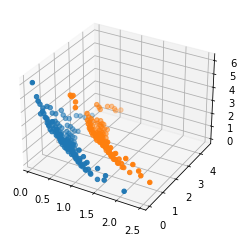

<Axes3DSubplot:>

In [11]:
plot(problem.pareto_front(), res_nsga3.F)

In [12]:
nsder = NSDER(ref_dirs=ref_dirs, pop_size=POPSIZE, CR=0.2, F=(0.1, 1.0), sampling=lhs, gamma=1e-4, refpoint=1.0,
             variant="DE/ranked/1/bin", SA=0.5)
    
res_nsder = moo_minimize(problem,
                         nsder,
                         ('n_gen', NGEN),
                         seed=SEED,
                         save_history=True,
                         verbose=True)

n_gen |  n_eval |     igd      |      gd     
    1 |     136 |  1.054281842 |  0.444228534
    2 |     272 |  1.066827094 |  0.441574368
    3 |     408 |  1.034382330 |  0.434556499
    4 |     544 |  1.034239947 |  0.425888297
    5 |     680 |  1.018706891 |  0.419333547
    6 |     816 |  1.018544502 |  0.408972034
    7 |     952 |  1.007075266 |  0.401452082
    8 |    1088 |  0.986201803 |  0.403953435
    9 |    1224 |  0.982085400 |  0.389717168
   10 |    1360 |  0.956146255 |  0.390073579
   11 |    1496 |  0.924199770 |  0.385256013
   12 |    1632 |  0.924199770 |  0.378699216
   13 |    1768 |  0.931099595 |  0.374717952
   14 |    1904 |  0.896782870 |  0.371991023
   15 |    2040 |  0.859797596 |  0.368997378
   16 |    2176 |  0.892964230 |  0.367086900
   17 |    2312 |  0.848584563 |  0.366973774
   18 |    2448 |  0.848170565 |  0.359924439
   19 |    2584 |  0.844306543 |  0.359053543
   20 |    2720 |  0.841794653 |  0.357611454
   21 |    2856 |  0.815449737 |  

%matplotlib qt

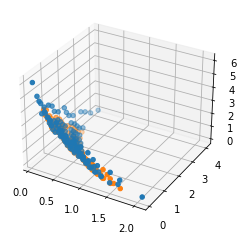

<Axes3DSubplot:>

In [13]:
plot(problem.pareto_front(), res_nsder.F)

In [ ]:
s